In [3]:
!pip install pmdarima


In [4]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from pmdarima.arima import auto_arima
from google.colab import drive
drive.mount('/content/gdrive')
%cd '/content/gdrive/MyDrive/somecode ML'
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import warnings
warnings.filterwarnings('ignore')


Mounted at /content/gdrive
/content/gdrive/MyDrive/somecode ML


In [5]:
# dateparse = lambda dates: pd.to_datetime(dates, format='%m/%d/%Y %M:%S')
mydata = pd.read_csv('VIC.csv',index_col='Date/Time')

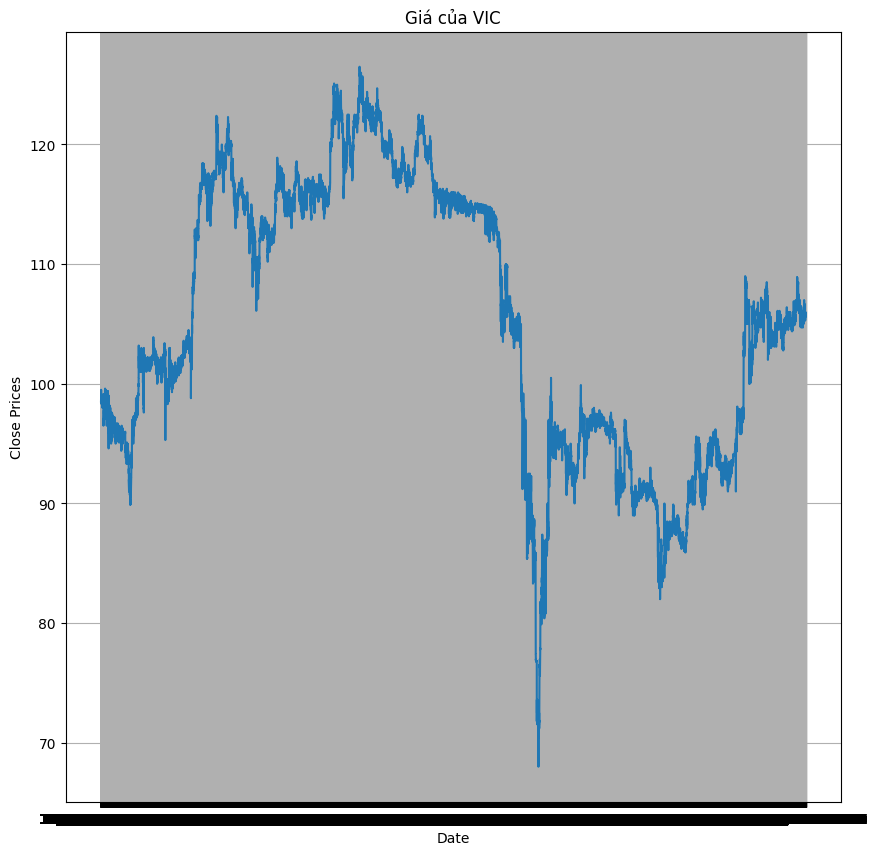

In [ ]:
plt.figure(figsize=(10,10))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(mydata['Close'])
plt.title('Giá của VIC')
plt.show()

In [6]:
def test_stationarity(timeseries):
    adft = adfuller(timeseries,autolag='AIC')
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

test_stationarity(mydata['Close'])

Test Statistics                    -1.621282
p-value                             0.472057
No. of lags used                   59.000000
Number of observations used    101206.000000
critical value (1%)                -3.430415
critical value (5%)                -2.861569
critical value (10%)               -2.566785
dtype: float64


In [7]:
from statsmodels.tsa.statespace.tools import diff
d_mydatad=diff(mydata['Close'])
test_stationarity(d_mydatad)

Test Statistics                   -44.206525
p-value                             0.000000
No. of lags used                   58.000000
Number of observations used    101206.000000
critical value (1%)                -3.430415
critical value (5%)                -2.861569
critical value (10%)               -2.566785
dtype: float64


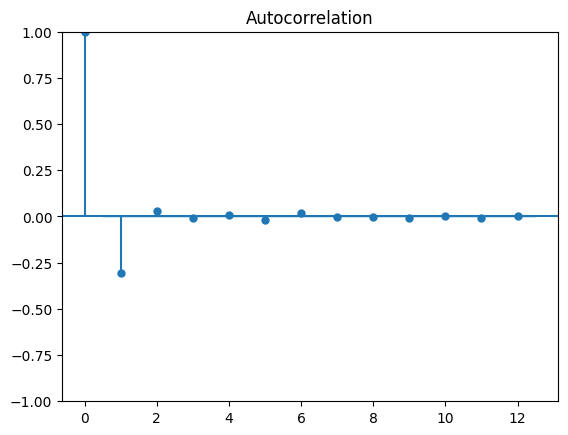

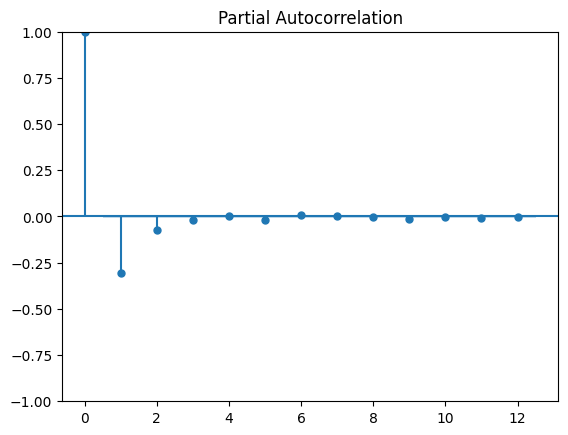

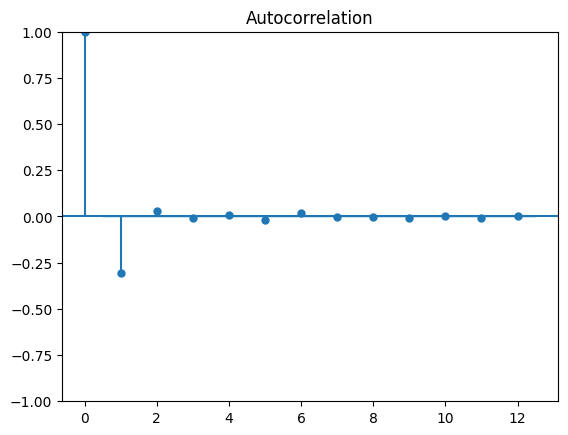

In [8]:
plot_pacf(d_mydatad,lags=12)
plot_acf(d_mydatad,lags=12)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-39250.582, Time=34.70 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-49029.696, Time=30.81 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-49503.070, Time=52.84 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-39252.569, Time=24.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-49577.746, Time=31.86 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-49576.519, Time=32.44 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-49577.870, Time=41.53 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-49575.765, Time=43.25 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-49574.946, Time=90.47 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-49597.873, Time=155.95 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-49576.569, Time=35.67 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-49594.845, Time=118.68 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=-49583.718, Time=64.80 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=-49574.594, Time

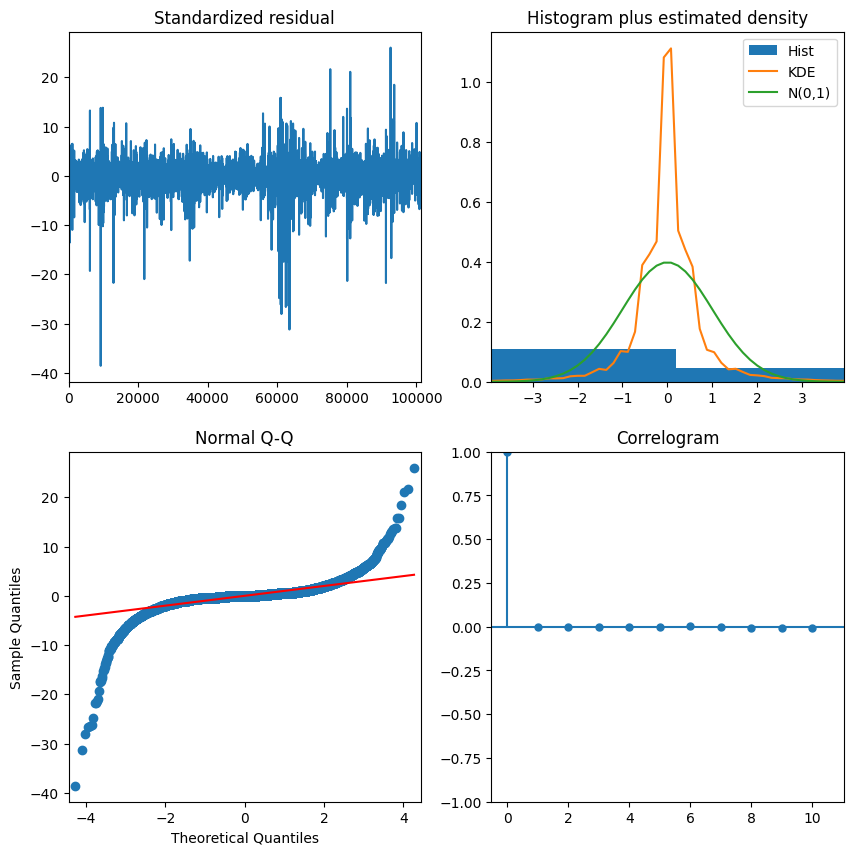

In [9]:
model_autoARIMA = auto_arima(mydata['Close'], start_p=0, start_q=0,
                      max_p=4, max_q=4,  # p tối đa và q tối đa
                      start_P=0,
                      d=1,
                      D=0,seasonal=False,
                      trace=True,
                      suppress_warnings=True,
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(10,10))
plt.show()

      Chi-Sq  Prob>Chi-Sq         F    Prob>F
1   0.002279     0.961928  0.002278  0.961929
2   0.084392     0.958682  0.042195  0.958683
3   0.270100     0.965550  0.090030  0.965552
4   0.297415     0.989980  0.074350  0.989981
5   0.319088     0.997269  0.063814  0.997269
6   0.593718     0.996504  0.098947  0.996505
7   0.665449     0.998587  0.095057  0.998588
8   0.846463     0.999045  0.105799  0.999045
9   1.261903     0.998558  0.140199  0.998558
10  2.352700     0.992853  0.235250  0.992854
11  3.118787     0.989061  0.283501  0.989064
12  3.131652     0.994541  0.260946  0.994543
   Jung-Box   JB-P-val Box-Pierce   BP-P-val
1   lb_stat  lb_pvalue    bp_stat  bp_pvalue
2   lb_stat  lb_pvalue    bp_stat  bp_pvalue
3   lb_stat  lb_pvalue    bp_stat  bp_pvalue
4   lb_stat  lb_pvalue    bp_stat  bp_pvalue
5   lb_stat  lb_pvalue    bp_stat  bp_pvalue
6   lb_stat  lb_pvalue    bp_stat  bp_pvalue
7   lb_stat  lb_pvalue    bp_stat  bp_pvalue
8   lb_stat  lb_pvalue    bp_stat  bp_pval

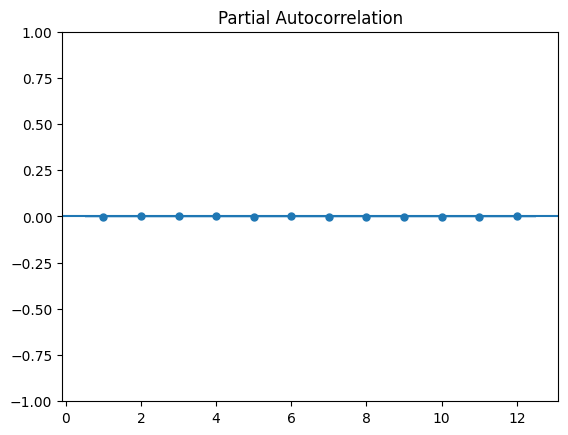

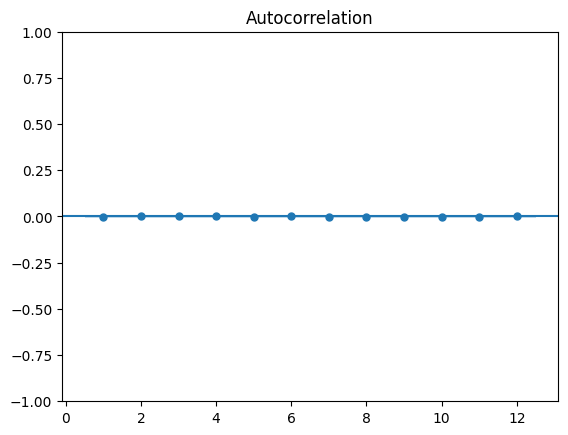

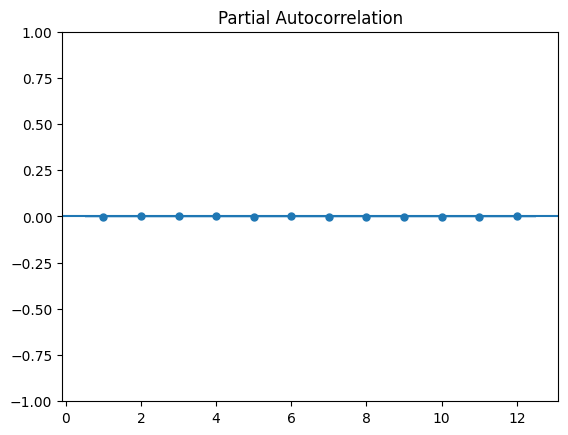

In [10]:
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
model = ARIMA(mydata['Close'], order=(3, 1, 4))
fitted = model.fit()
fitted.summary()
resids= fitted.resid
lags=12

### Kiểm định tương quan chuỗi BG
chi2=np.zeros(lags)
probChi2=np.zeros(lags)
F=np.zeros(lags)
probf=np.zeros(lags)
for i in range(lags):
    chi2[i],probChi2[i],F[i],probf[i] = sm.stats.diagnostic.acorr_breusch_godfrey(fitted,i+1)
BG_test = pd.DataFrame({'Chi-Sq': chi2, 'Prob>Chi-Sq': probChi2,
                        'F': F, 'Prob>F': probf}, index=range(1,lags+1))
print(BG_test)


### Kiểm định tương quan chuỗi Ljing-Box test

lags =12  # required for the following tests
jb, jbpv, bp, bppv = sm.stats.diagnostic.acorr_ljungbox(resids,lags,True,return_df=False)
JB_test = pd.DataFrame({'Jung-Box': jb,
                    'JB-P-val': jbpv,
                   'Box-Pierce': bp,
                   'BP-P-val': bppv},
                   index=range(1,lags+1))
print(JB_test)


# check for residual autocorrelation ACF and PACF
import statsmodels.graphics.tsaplots as tsaplt
import statsmodels.tsa.api as tsa

acf, acf_confint, lbq, lbqpv = tsa.acf(resids, nlags=lags, alpha=0.05, qstat=True, fft=False)
pacf, pacf_confint = tsa.pacf(resids, nlags=lags, alpha=0.05)
acf_se = (acf_confint[:,1]-acf)/1.96
pacf_se = (pacf_confint[:,1]-pacf)/1.96

ACF_table = pd.DataFrame({'AR': acf[1:], 'AR_se': acf_se[1:],
                          'PAR': pacf[1:], 'PAR_se': pacf_se[1:],
                          'Ljung-Box Q': lbq, 'Q_pval': lbqpv},
                    index=range(1,lags+1))
print(ACF_table)

# plots of ACF and Pacf
tsaplt.plot_acf(fitted.resid, lags=lags, zero=False)
tsaplt.plot_pacf(fitted.resid, lags=lags, zero=False)





In [14]:

predictions = fitted.predict(start=0, end=101265, dynamic=False).rename('ARIMA(3, 1, 4) Dự báo')
for i in range(len(predictions)):
    print(f"Giá trị dự báo={predictions[i]:<11.10}, Giá trị thực tế={mydata['Close'][i]}")
title = 'Kết quả dự báo trong mẫu'


Streaming output truncated to the last 5000 lines.
Giá trị dự báo=105.0920535, Giá trị thực tế=105.2
Giá trị dự báo=105.1947975, Giá trị thực tế=105.2
Giá trị dự báo=105.2032676, Giá trị thực tế=105.4
Giá trị dự báo=105.329049 , Giá trị thực tế=105.5
Giá trị dự báo=105.4348361, Giá trị thực tế=105.6
Giá trị dự báo=105.5698963, Giá trị thực tế=105.6
Giá trị dự báo=105.5932927, Giá trị thực tế=105.5
Giá trị dự báo=105.5158685, Giá trị thực tế=105.6
Giá trị dự báo=105.571581 , Giá trị thực tế=105.0
Giá trị dự báo=105.2025683, Giá trị thực tế=103.8
Giá trị dự báo=104.2329661, Giá trị thực tế=103.2
Giá trị dự báo=103.4955525, Giá trị thực tế=103.2
Giá trị dự báo=103.2822841, Giá trị thực tế=103.2
Giá trị dự báo=103.2353468, Giá trị thực tế=104.9
Giá trị dự báo=104.3549603, Giá trị thực tế=104.5
Giá trị dự báo=104.492512 , Giá trị thực tế=104.2
Giá trị dự báo=104.2864274, Giá trị thực tế=104.2
Giá trị dự báo=104.2353993, Giá trị thực tế=104.2
Giá trị dự báo=104.1824648, Giá trị thực tế=103.9

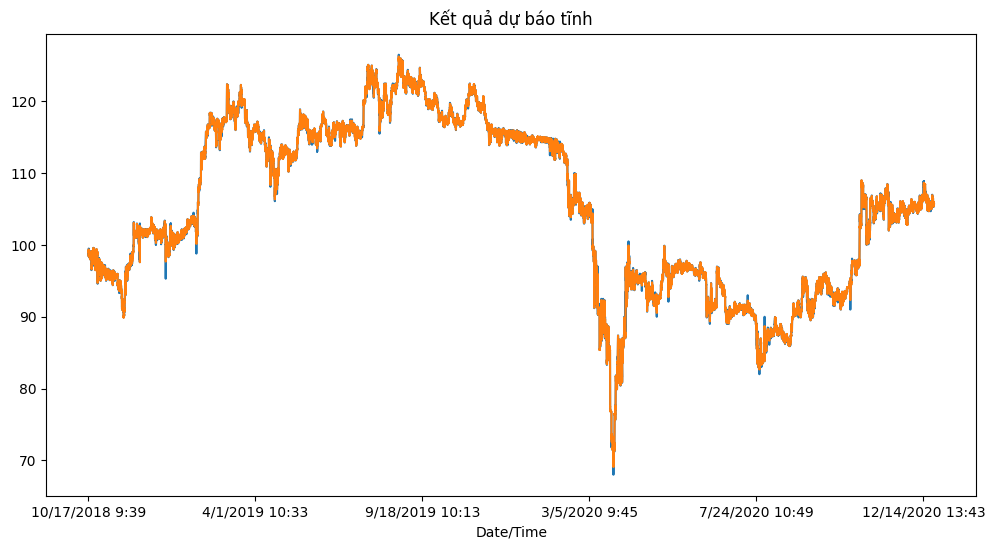

In [15]:
dynamic = fitted.predict(start=1, end=101266, dynamic=False).rename('ARIMA(3, 1, 4) Forecast')
title = 'Kết quả dự báo tĩnh'
xlabel='Week'
ax = mydata['Close'].plot(legend=False,figsize=(12,6),title=title)
dynamic.plot(legend=False)
ax.autoscale(axis='x',tight=False)


In [16]:
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

MSE = mean_squared_error(mydata['Close'], dynamic)
RMSE = rmse(mydata['Close'], dynamic)
MAE = mean_absolute_error(mydata['Close'], dynamic)
MAPE = np.mean(np.abs(dynamic - mydata['Close'])/np.abs(mydata['Close']))
print(f'ARIMA(0,1,0) MSE : {MSE:11.10}')
print(f'ARIMA(0,1,0) RMSE : {RMSE:11.10}')
print(f'ARIMA(0,1,0) MAE : {MAE:11.10}')
print(f'ARIMA(0,1,0) MAPE : {MAPE:11.10}')


ARIMA(0,1,0) MSE : 0.003859833334
ARIMA(0,1,0) RMSE : 0.06212755696
ARIMA(0,1,0) MAE : 0.03179214622
ARIMA(0,1,0) MAPE :         nan


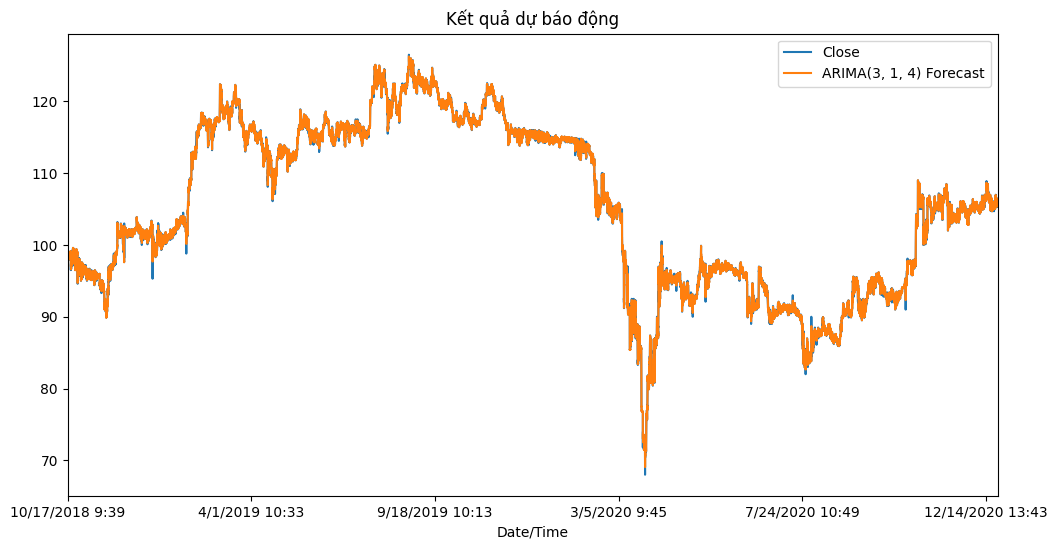

In [17]:
static = fitted.predict(start=1, end=101266, dynamic=False).rename('ARIMA(3, 1, 4) Forecast')
title = 'Kết quả dự báo động'
xlabel='Week'

ax = mydata['Close'].plot(legend=True,figsize=(12,6),title=title)
static.plot(legend=True)
ax.autoscale(axis='x',tight=True)


In [18]:
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

MSE = mean_squared_error(mydata['Close'], static)
RMSE = rmse(mydata['Close'], static)
MAE = mean_absolute_error(mydata['Close'], static)
MAPE = np.mean(np.abs(static - mydata['Close'])/np.abs(mydata['Close']))
print(f'ARIMA(4,1,0) MSE : {MSE:11.10}')
print(f'ARIMA(4,1,0) RMSE : {RMSE:11.10}')
print(f'ARIMA(4,1,0) MAE : {MAE:11.10}')
print(f'ARIMA(4,1,0) MAPE : {MAPE:11.10}')

ARIMA(4,1,0) MSE : 0.003859833334
ARIMA(4,1,0) RMSE : 0.06212755696
ARIMA(4,1,0) MAE : 0.03179214622
ARIMA(4,1,0) MAPE :         nan


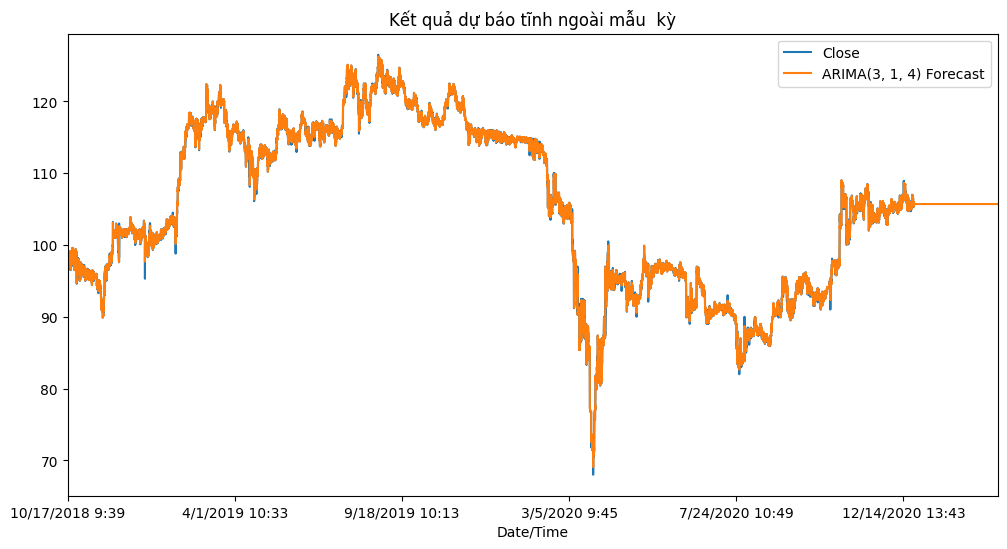

In [19]:
dynamic = fitted.predict(start=1, end=101266+10000, dynamic=False).rename('ARIMA(3, 1, 4) Forecast')
title = 'Kết quả dự báo tĩnh ngoài mẫu  kỳ'
xlabel='Week'

ax = mydata['Close'].plot(legend=True,figsize=(12,6),title=title)
dynamic.plot(legend=True)
ax.autoscale(axis='x',tight=True)
